In [1]:
# Install Libraries & Roms
# !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
# %pip install -U tf-agents pyvirtualdisplay
# %pip install -U gym>=0.21.0
# %pip install -U gym[box2d,atari,accept-rom-license]

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import Libraries

# Tensor Flow
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common
import numpy as np
import os
import random

# Gym
import gym

# Visualise
import pyvirtualdisplay

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "./gdrive/MyDrive/ML"
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


## Task 1.1 Create Environment

In [5]:
env = gym.make("Assault-v4")
height, width, channels = env.observation_space.shape

# print("Action space: ", env.action_space)
# print("Observation space: ", env.observation_space)

env.reset()
next_obs, reward, done, info = env.step(0)
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

## Task 1.3: Pre-Processing

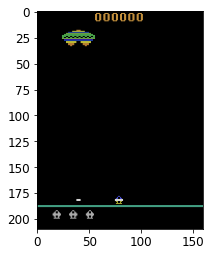

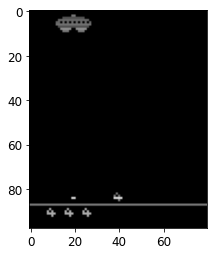

In [6]:
obs = env.reset()

def preprocess_observation(observation):

    # Slice Top Off
    img = observation[14:210:2, ::2]

    # Grey Scale
    img = img.mean(axis=2)
    img = (img - 128).astype(np.int8)

    return img.reshape(98, 80, 1)

plt.imshow(obs)
plt.show()
plt.imshow(preprocess_observation(obs).reshape(98, 80), cmap="gray", vmin=-128, vmax=127)

## Task 1.4: Implement Deep Convolutional Network

In [7]:
def q_network(X_state, name):
    prev_layer = X_state / 128 #the values will be between [-1, 1]
    initializer = tf.compat.v1.variance_scaling_initializer()
    hidden_activation = tf.nn.relu
    with tf.compat.v1.variable_scope(name) as scope:
        prev_layer = tf.compat.v1.layers.conv2d(prev_layer, filters=32,
                                      kernel_size = 8, strides = 4,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        prev_layer = tf.compat.v1.layers.conv2d(prev_layer, filters=64,
                                      kernel_size = 4, strides = 2,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        prev_layer = tf.compat.v1.layers.conv2d(prev_layer, filters=64,
                                      kernel_size = 3, strides = 1,
                                      padding="SAME", activation= hidden_activation,
                                      kernel_initializer = initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape= [-1, 8320])
        hidden = tf.compat.v1.layers.dense(last_conv_layer_flat, 512, activation = hidden_activation, kernel_initializer = initializer)
        hidden = tf.compat.v1.layers.dense(hidden, 256, activation=hidden_activation, kernel_initializer = initializer)
        hidden = tf.compat.v1.layers.dense(hidden, 128, activation=hidden_activation, kernel_initializer = initializer)
        outputs = tf.compat.v1.layers.dense(hidden, env.action_space.n, kernel_initializer = initializer)
    trainable_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)
    trainable_vars_by_name = { var.name[len(scope.name):] : var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [8]:
class QLearningAgent():
    def __init__(self, env, learning_rate = 0.001, momemtum = 0.95):
        self.action_size = env.action_space.n
        self.loss_val = np.infty
        tf.compat.v1.reset_default_graph()
        tf.compat.v1.disable_eager_execution()

        self.discount_rate = 0.99

        self.checkpoint_path = "./drive/MyDrive/ML/ScreenTestWithGraph/my_dqn_assault.ckpt"

        self.X_state = tf.compat.v1.placeholder(tf.float32, shape= [None, 98, 80, 1])
        self.online_q_values, self.online_vars = q_network(self.X_state, name = "q_networks/online")
        self.target_q_values, self.target_vars = q_network(self.X_state, name = "q_networks/target")

        #Define the operations to copy the online network to the target network
        self.copy_ops = [ target_var.assign(self.online_vars[var_name])
                          for var_name, target_var in self.target_vars.items()]
        self.copy_online_to_target = tf.group(*self.copy_ops)

        # The structure of the training
        with tf.compat.v1.variable_scope("train"):
            self.X_action = tf.compat.v1.placeholder(tf.int32, shape=[None])
            self.y = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
            self.q_value = tf.reduce_sum(self.online_q_values * tf.one_hot(self.X_action, self.action_size),
                                         axis=1, keepdims = True)

            self.error = tf.abs( self.y - self.q_value) #A value between 0 and infty
            self.clipped_error = tf.clip_by_value(self.error, 0.0, 1.0) #If it is above 1 then it becomes 1
            self.linear_error = 2 * (self.error - self.clipped_error)
            self.loss = tf.reduce_mean(tf.square(self.clipped_error) + self.linear_error)

            self.global_step = tf.Variable(0, trainable = False, name = "global_step")
            self.test_step = tf.Variable(0, trainable = False, name = "test_step")
            self.optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum = momemtum, use_nesterov = True)
            self.training_op = self.optimizer.minimize(self.loss, global_step = self.global_step)

        # Saving
        self.saver = tf.compat.v1.train.Saver()
        self.sess = tf.compat.v1.Session()
        if os.path.isfile(self.checkpoint_path + ".index"):
            self.saver.restore(self.sess, self.checkpoint_path)
        else:
            self.sess.run(tf.compat.v1.global_variables_initializer())
            self.sess.run(self.copy_online_to_target)

        self.testsess = tf.compat.v1.Session()

    def get_action(self, q_values, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(q_values)



    def train(self, state_val, action_val, reward, next_state_val, continues):
        next_q_values = self.target_q_values.eval(feed_dict={self.X_state : np.array([next_state_val])})
        max_next_q_values = np.max(next_q_values , axis = 1, keepdims= True)
        #We can now compute the target value
        y_val = reward + continues * self.discount_rate *max_next_q_values
        _ , self.loss_val = self.sess.run([self.training_op, self.loss],
                                          feed_dict= {self.X_state: np.array([state_val]),
                                                      self.X_action: np.array([action_val]),
                                                      self.y : y_val})

In [9]:
# Animation Helpers
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Agent Evaluation
def evaluate_agent(agent, episodes):

    frames = []
    rewards = []
    s= 0
    
    with agent.sess:

        state = preprocess_observation(env.reset())
        
        episode = 0

        for i in range(episodes):

            rewards.append(0)

            while True:

                img = env.render(mode="rgb_array")
                frames.append(img)

                q_values = agent.online_q_values.eval(feed_dict={agent.X_state : [state]})
                action = agent.get_action(q_values, step)

                obs, reward, done, info = env.step(action)
                rewards[i] += reward

                state = preprocess_observation(obs)
                
                if done:
                    print("Episode {} Total Reward: {}".format(i + 1, rewards[i]))
                    state = preprocess_observation(env.reset())
                    break
      
    return frames, rewards

Requirements when running this:
1.   Have the file path drive/MyDrive/ML
2.   Make sure your happy with the testInterval and testEpisodes values

In [13]:
# Plotting means gathered in previous step
def plotRewardGraph(rewards, testingIntervals, totalSteps):
    l = len(rewards)
    x_vals = [x for x in range(totalSteps + 1) if x % testingIntervals == 0]
    assert l == len(x_vals)

    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot()

    ax.plot(rewards, 'bo-', label="Mean Test Score", color="red", alpha=0.6, linewidth=3)
    plt.xticks(range(0, len(x_vals)), x_vals)
    ax.locator_params(axis='x', nbins=len(x_vals))
    plt.xlabel('Steps Trained'); plt.ylabel(r'Average Testing Score')
    plt.title(r'Average Time Taken for Ascending Input Size')

    plt.savefig("./drive/MyDrive/ML/{}_Plot.pdf".format('Average_Testing_Score'), dpi=500)
    plt.show()

In [ ]:
# Train Agent
agent = QLearningAgent(env)

n_steps = 1000000
copy_steps = 5000
save_steps = 100

with agent.sess:

    state = preprocess_observation(env.reset())


    while True:
        step = agent.global_step.eval()
        if step >= n_steps:
            break


        print("\r\t Training step {}/{} ({:.1f})% \t Loss{:5f}".format(step,n_steps,step*100/ n_steps,agent.loss_val), end="")

        if done:
            obs = env.reset()
            state = preprocess_observation(obs)

        q_values = agent.online_q_values.eval(feed_dict={agent.X_state : [state]})
        action = agent.get_action(q_values,step)

        #We play the action from the agent
        next_obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(next_obs)
        agent.train(state, action, reward, next_state, 1.0 - done)

        env.render(mode="rgb")

        state = next_state

        if step % copy_steps ==0:
            agent.copy_online_to_target.run()

        if step % save_steps ==0:
            agent.saver.save(agent.sess, agent.checkpoint_path)

## Testing

In [ ]:
env.reset()
agent = QLearningAgent(env)

frames, rewards = evaluate_agent(agent, 1)
print("Mean Reward: ", np.mean(rewards))

plot_animation(frames)